## Jupyter notebook to start cleaning the data for future prediction.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from wordcloud import STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')#Sentence tokenizer
from sklearn.model_selection import train_test_split
import os
from flask import Flask, flash, request, redirect, url_for
from zipfile import ZipFile

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joaquin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
dir_data_train = './train.csv'
dir_data_test = './test.csv'

In [7]:
df_test = pd.read_csv(dir_data_test)
df_train = pd.read_csv(dir_data_train)

Let's see a feww rows

In [8]:
pd.set_option('max_colwidth', 1000)
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


## Keyword and Location.
We can take a look to these variables.

In [9]:
key_freq = df_train['keyword'].value_counts()


In [10]:
key_freq[:20]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
Name: keyword, dtype: int64

Where the keyword is empty we place the value no_keyword. Same with Location.

In [11]:
df_train.keyword = df_train.keyword.apply(lambda x: str(x))

In [12]:
df_train.keyword = df_train.keyword.apply(lambda x:'no_keyword' if x == 'nan' else x)

In [13]:
key_freq = df_train['keyword'].value_counts()

In [14]:
type(key_freq)

pandas.core.series.Series

In [15]:
key_freq.keys()


Index(['no_keyword', 'fatalities', 'deluge', 'armageddon', 'sinking', 'damage',
       'harm', 'body%20bags', 'evacuate', 'fear',
       ...
       'volcano', 'battle', 'bush%20fires', 'war%20zone', 'rescue',
       'forest%20fire', 'epicentre', 'threat', 'inundation',
       'radiation%20emergency'],
      dtype='object', length=222)

In [16]:
keyword_dic = {}

In [17]:
keyword_dic['no_keyword'] = key_freq['no_keyword']

In [18]:
keyword_dic['all_keyword'] = sum(key_freq[key_freq.keys()!='no_keyword'])

In [19]:
keyword_dic

{'no_keyword': 61, 'all_keyword': 7552}

<BarContainer object of 2 artists>

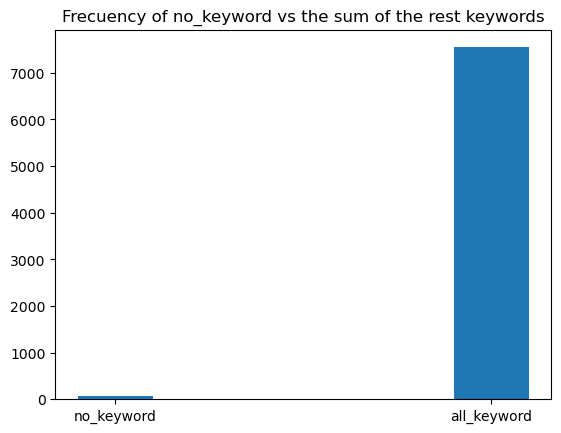

In [20]:
x = keyword_dic.keys()
heigh = keyword_dic.values()
plt.title('Frecuency of no_keyword vs the sum of the rest keywords')
plt.bar(x, heigh, width=0.2,align= 'center')

No we do the same analysis with the location feature.

In [21]:
df_train.location = df_train.location.apply(lambda x: str(x))

In [22]:
df_train.location = df_train.location.apply(lambda x:'no_location' if x == 'nan' else x)

In [23]:
location_freq = df_train.location.value_counts()

In [24]:
location_dict = {}

In [25]:
location_dict['no_location'] = location_freq['no_location']

In [26]:
location_dict['location'] = sum(location_freq[location_freq.keys() != 'no_location'])

<BarContainer object of 2 artists>

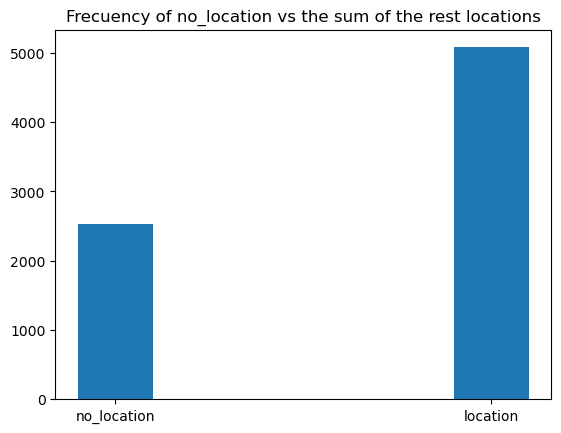

In [27]:
x = location_dict.keys()
heigh = location_dict.values()
plt.title('Frecuency of no_location vs the sum of the rest locations')
plt.bar(x, heigh, width=0.2,align= 'center')

We can see some difference between these two features. In keyword we have only miss less than the ten percent, so we will conserve it. In the case of the location, we don't have information of the 30%, thats because we will drop it. 

## Twitts

We will start the cleaning of the twits. First we can look at the twits and visualize the most frequent words.

In [28]:
def gen_freq(text):
    #Will store the list of words
    word_list = []

    #Loop over all the tweets and extract words into word_list
    for tw_words in text.split():
        word_list.extend(tw_words)

    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()

    #Print top 20 words
    word_freq[:20]
    
    return word_freq

word_freq = gen_freq(df_train.text.str)

In [29]:
word_freq[:20]

the     2575
a       1845
to      1805
in      1757
of      1722
and     1302
I       1197
for      820
is       814
on       773
-        763
you      632
The      552
my       549
with     508
that     492
at       485
by       469
it       433
from     372
dtype: int64

We found something that we could imagine, the most frequents words are articles. Lets visualize the data using word clouds.

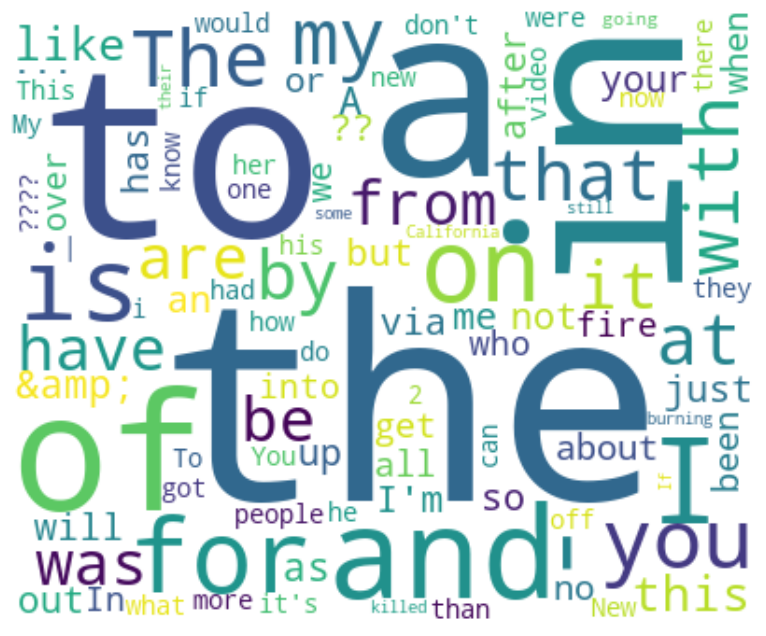

In [30]:
#Generate word cloud
wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

**Few things to Note:**

1. There is noise in the form of "&amp" which can be removed from the word frequency.
2. Stop words like "the", "in", "to", "of" etc. are obviously ranking among the top frequency words but these are just constructs of the English language and are not specific to the people's tweets.
3. We can **Normalized** the text.

The above are some of the problems that we need to address in order to make better visualization. Let's solve some of the problems!

In [31]:
#Clean text from noise
def clean_text(text):
    #Filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    #Convert to lowercase to maintain consistency
    text = text.lower()
       
    return text


In [32]:
df_train['clean_text'] = df_train.text.apply(lambda x: clean_text(x))

In [33]:
from wordcloud import STOPWORDS

#Generate word frequency
def gen_freq_stop_words(text):
    #Will store the list of words
    word_list = []

    #Loop over all the tweets and extract words into word_list
    for tw_words in text.split():
        word_list.extend(tw_words)

    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()
    
    #Drop the stopwords during the frequency calculation
    word_freq = word_freq.drop(STOPWORDS, errors='ignore')
    
    return word_freq

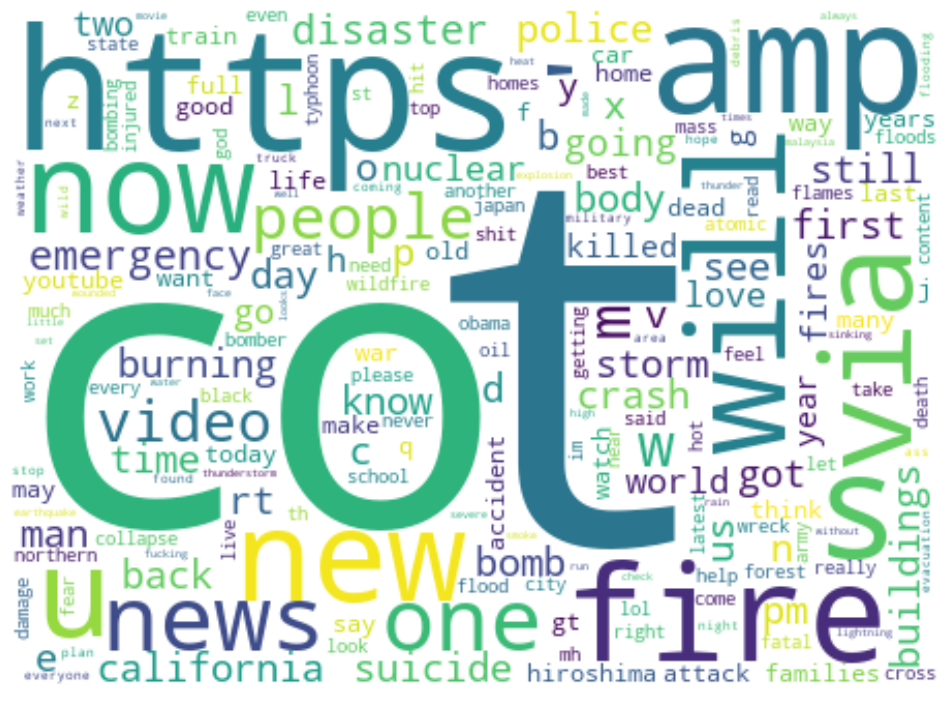

In [34]:
text = df_train.text.apply(lambda x: clean_text(x))
word_freq = gen_freq_stop_words(text.str)*100

#Generate word cloud
wc = WordCloud(width=450, height=330, max_words=200, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 14))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

We still see words as 'co', 't', 'amp', 'https', etc. We can clean a bit more, and lemmatize.

In [35]:
lemm = WordNetLemmatizer() # Inicialice lemmatizer. 

In [36]:
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: lemm.lemmatize(x))

To try a very simple model. The idea is to create a bag of words, and then create one array for each twitt, with the length of the size of the bag of words. Then we will put 1 if the word is in the twitt or 0 if itsn't.

In [37]:
bag_of_words = []
for sentence in df_train.clean_text:
    bag_of_words.extend(nltk.word_tokenize(sentence))


In [38]:
bag_of_words = [lemm.lemmatize(x) for x in bag_of_words if x not in STOPWORDS]
bag_of_words= set(bag_of_words)

In [39]:
len(bag_of_words)

21000

We have, so far, a bag with 21000 words, we will add the keywords.

In [40]:
for key in df_train.keyword.unique():
    bag_of_words.add(key) 

As this thabase is from a kaggel competition, we dont have the target of the test set, so we will split the training set to see how our moodel perform.

In [41]:
df_train['X'] = df_train['clean_text'] + ' ' + df_train['keyword']

In [42]:
df_train['X']

0                                                                           our deeds are the reason of this  earthquake may allah forgive us all no_keyword
1                                                                                                          forest fire near la ronge sask  canada no_keyword
2           all residents asked to 'shelter in place' are being notified by officers  no other evacuation or shelter in place orders are expected no_keyword
3                                                                                      people receive  wildfires evacuation orders in california  no_keyword
4                                                        just got sent this photo from ruby  alaska as smoke from  wildfires pours into a school  no_keyword
                                                                                ...                                                                         
7608                                                      

As this thabase is from a kaggel competition, we dont have the target of the test set, so we will split the training set to see how our moodel perform.

In [43]:
X = df_train.X
y = df_train.target

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=2)

In [45]:
training =[]
output_empty = [0]
for i,twitt in enumerate(X_train):
    bag = []
    pattern_words = [lemm.lemmatize(word.lower()) for word in twitt]
    # create bag of words array,if word match found in current pattern then put 1 otherwise 0.[row * colm(263)]
    for w in bag_of_words:
        bag.append(1) if w in pattern_words else bag.append(0)
    output_row = list(output_empty)
    output_row = (y_train.iloc[i])
    training.append([bag, output_row])
training = np.array(training)

C:\Users\Joaquin\AppData\Local\Temp\ipykernel_11528\1630246747.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)


In [46]:
train_x = list(training[:,0])
train_y = list(training[:,1])

We have to transform our X_test to the 'train_x' format.

In [47]:
test =[]
for i,twitt in enumerate(X_test):
    bag = []
    pattern_words = [lemm.lemmatize(word.lower()) for word in twitt]
    # create bag of words array,if word match found in current pattern then put 1 otherwise 0.[row * colm(263)]
    for w in bag_of_words:
        bag.append(1) if w in pattern_words else bag.append(0)
    test.append(bag)

Now we will save the data to train a model. For this we will use Pickle.
Because of the size of the files, we will create zip files.

In [48]:
import pickle
  
# Create a variable
myvar = test
  
# Open a file and use dump()
with open('test.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(myvar, file)

# specifying the zip file name
file_name = "test.zip"
  
with ZipFile(file_name, 'w') as myzip:
    myzip.write('test.pkl')



In [49]:
# Create a variable
myvar = y_test
  
# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(myvar, file)

# specifying the zip file name
file_name = "y_test.zip"
  
with ZipFile(file_name, 'w') as myzip:
    myzip.write('y_test.pkl')


In [50]:
# Create a variable
myvar = train_x
  
# Open a file and use dump()
with open('train_x.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(myvar, file)

# specifying the zip file name
file_name = "train_x.zip"
  
with ZipFile(file_name, 'w') as myzip:
    myzip.write('train_x.pkl')

In [51]:
# Create a variable
myvar = train_y
  
# Open a file and use dump()
with open('train_y.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(myvar, file)

# specifying the zip file name
file_name = "train_y.zip"
  
with ZipFile(file_name, 'w') as myzip:
    myzip.write('train_y.pkl')